In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

import nltk
from nltk.corpus import stopwords
sw = stopwords.words('spanish') # descargamos la lista de stopwords
sw.remove("no")
from wordcloud import WordCloud

from sklearn.feature_extraction.text import  TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

os.chdir('../')
from Funciones.funciones import texto_limpio,texto_raiz
os.chdir('Analisis-PreProcess')

# Carga data y creación Dataframe

In [2]:

data = pd.read_csv(r'..\Datos\dataset_mercado_publico.csv', delimiter=';')
data.head()

,Tender_id,Item_Key,Rubro1,Rubro2,Rubro3,Nombre linea Adquisicion,Descripcion linea Adquisicion,Kupfer
0,2792-88-LE21,2792-88-LE21-1,Equipamiento y suministros médicos,Productos quirúrgicos,"Equipo quirúrgico, accesorios y productos rela...",Equipo quirúrgico de fragmatome retinal vítreo...,CÁMARA RETINAL NO MIDRIÁTICA - ESPECIFICACIONE...,0
1,1704-52-LP21,1704-52-LP21-1,"Servicios de transporte, almacenaje y correo",Transporte de correo y carga,Transporte de carga por carretera,Servicios de transporte local en camión,SERVICIO DE MUDANZA DE ENSERES PROPIOS Y EN US...,0
2,1003-20-L121,1003-20-L121-1,"Productos derivados de minerales, plantas y an...",Chatarra y desechos no metálicos,Desechos no metálicos,Desperdicios o restos de madera,LEÑA SECA CERTIFICADA,0
3,903556-3-LP21,903556-3-LP21-1,"Tecnologías de la información, telecomunicacio...",Software,Software de administración de redes,Software de administración,NaN,0
4,4236-21-L121,4236-21-L121-1,"Equipos, accesorios y suministros de oficina",Suministros de oficina,Instrumentos de escritura,Marcadores,MARCADOR BLANCO PARA METALES,0


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54962 entries, 0 to 54961
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   Tender_id                      54962 non-null  object
 1   Item_Key                       54962 non-null  object
 2   Rubro1                         54962 non-null  object
 3   Rubro2                         54962 non-null  object
 4   Rubro3                         54962 non-null  object
 5   Nombre linea Adquisicion       54962 non-null  object
 6   Descripcion linea Adquisicion  54849 non-null  object
 7   Kupfer                         54962 non-null  int64 
dtypes: int64(1), object(7)
memory usage: 3.4+ MB


In [8]:
data[['Item_Key']].sort_values('Item_Key', ascending=True)

,Item_Key
10235,1000-26-LE21-1
10236,1000-26-LE21-2
54368,1000-34-LE21-2
54346,1000-34-LE21-3
10237,1000813-41-LE21-1
...,...
8405,999-73-L121-5
8406,999-73-L121-7
8407,999-73-L121-8
10028,999-74-LE21-1


# Preprocesamiento Data

In [3]:
df = data.copy()
df = df.rename(columns={'Tender_id':'id_licitacion','Item_Key':'id_producto','Nombre linea Adquisicion':'nombre_producto','Descripcion linea Adquisicion':'descripcion','Kupfer':'label'})
df.head()

,id_licitacion,id_producto,Rubro1,Rubro2,Rubro3,nombre_producto,descripcion,label
0,2792-88-LE21,2792-88-LE21-1,Equipamiento y suministros médicos,Productos quirúrgicos,"Equipo quirúrgico, accesorios y productos rela...",Equipo quirúrgico de fragmatome retinal vítreo...,CÁMARA RETINAL NO MIDRIÁTICA - ESPECIFICACIONE...,0
1,1704-52-LP21,1704-52-LP21-1,"Servicios de transporte, almacenaje y correo",Transporte de correo y carga,Transporte de carga por carretera,Servicios de transporte local en camión,SERVICIO DE MUDANZA DE ENSERES PROPIOS Y EN US...,0
2,1003-20-L121,1003-20-L121-1,"Productos derivados de minerales, plantas y an...",Chatarra y desechos no metálicos,Desechos no metálicos,Desperdicios o restos de madera,LEÑA SECA CERTIFICADA,0
3,903556-3-LP21,903556-3-LP21-1,"Tecnologías de la información, telecomunicacio...",Software,Software de administración de redes,Software de administración,NaN,0
4,4236-21-L121,4236-21-L121-1,"Equipos, accesorios y suministros de oficina",Suministros de oficina,Instrumentos de escritura,Marcadores,MARCADOR BLANCO PARA METALES,0


In [4]:
df.index = df['id_producto']
df.head()

,id_licitacion,id_producto,Rubro1,Rubro2,Rubro3,nombre_producto,descripcion,label
id_producto,,,,,,,,
2792-88-LE21-1,2792-88-LE21,2792-88-LE21-1,Equipamiento y suministros médicos,Productos quirúrgicos,"Equipo quirúrgico, accesorios y productos rela...",Equipo quirúrgico de fragmatome retinal vítreo...,CÁMARA RETINAL NO MIDRIÁTICA - ESPECIFICACIONE...,0
1704-52-LP21-1,1704-52-LP21,1704-52-LP21-1,"Servicios de transporte, almacenaje y correo",Transporte de correo y carga,Transporte de carga por carretera,Servicios de transporte local en camión,SERVICIO DE MUDANZA DE ENSERES PROPIOS Y EN US...,0
1003-20-L121-1,1003-20-L121,1003-20-L121-1,"Productos derivados de minerales, plantas y an...",Chatarra y desechos no metálicos,Desechos no metálicos,Desperdicios o restos de madera,LEÑA SECA CERTIFICADA,0
903556-3-LP21-1,903556-3-LP21,903556-3-LP21-1,"Tecnologías de la información, telecomunicacio...",Software,Software de administración de redes,Software de administración,NaN,0
4236-21-L121-1,4236-21-L121,4236-21-L121-1,"Equipos, accesorios y suministros de oficina",Suministros de oficina,Instrumentos de escritura,Marcadores,MARCADOR BLANCO PARA METALES,0


In [5]:
#df.drop(columns=['id_licitacion','id_producto','Rubro2','Rubro3'], inplace=True)
df.drop(columns=['id_licitacion','id_producto'], inplace=True)
df.head()

,Rubro1,Rubro2,Rubro3,nombre_producto,descripcion,label
id_producto,,,,,,
2792-88-LE21-1,Equipamiento y suministros médicos,Productos quirúrgicos,"Equipo quirúrgico, accesorios y productos rela...",Equipo quirúrgico de fragmatome retinal vítreo...,CÁMARA RETINAL NO MIDRIÁTICA - ESPECIFICACIONE...,0
1704-52-LP21-1,"Servicios de transporte, almacenaje y correo",Transporte de correo y carga,Transporte de carga por carretera,Servicios de transporte local en camión,SERVICIO DE MUDANZA DE ENSERES PROPIOS Y EN US...,0
1003-20-L121-1,"Productos derivados de minerales, plantas y an...",Chatarra y desechos no metálicos,Desechos no metálicos,Desperdicios o restos de madera,LEÑA SECA CERTIFICADA,0
903556-3-LP21-1,"Tecnologías de la información, telecomunicacio...",Software,Software de administración de redes,Software de administración,NaN,0
4236-21-L121-1,"Equipos, accesorios y suministros de oficina",Suministros de oficina,Instrumentos de escritura,Marcadores,MARCADOR BLANCO PARA METALES,0


In [12]:
df.isnull().sum()

Rubro1               0
Rubro2               0
Rubro3               0
nombre_producto      0
descripcion        113
label                0
dtype: int64

In [13]:
datos_perdidos = df[df['descripcion'].isnull() == True]
datos_perdidos

,Rubro1,Rubro2,Rubro3,nombre_producto,descripcion,label
id_producto,,,,,,
903556-3-LP21-1,"Tecnologías de la información, telecomunicacio...",Software,Software de administración de redes,Software de administración,NaN,0
3596-11-LE21-1,"Equipos y suministros de defensa, orden públic...",Seguridad y control público,Control de tráfico,Badén reductor de velocidad (lomo de toro),NaN,0
2831-32-LE21-1,"Instrumentos musicales, juegos, juguetes, arte...","Equipos de arte y manualidades, accesorios y s...",Suministros y accesorios de escultura,Juguetes táctiles,NaN,0
2179-76-LE21-1,Servicios de construcción y mantenimiento,"Servicios de atención, mantenimiento y reparac...","Gasfitería, calefacción y aire acondicionado","Instalación, reparación o mantenimiento de sis...",NaN,0
2180-43-LE21-1,Servicios de cuidado personal y domésticos,Servicio doméstico y de cuidados,Asistencia y cuidado doméstico,Servicios de mantenimiento de patios y piscinas,NaN,0
...,...,...,...,...,...,...
809-17-LE21-2,"Servicios profesionales, administrativos y con...",Consultorías o asesorías en gestión empresarial,Servicios de consultoría en gestión de empresas,Asesorías en inteligencia de negocios,NaN,0
809-28-LE21-1,"Servicios profesionales, administrativos y con...",Servicios para la comercialización y distribución,Ventas y marketing,Capacitaciones directas en el concesionario,NaN,0
809-30-LE21-1,"Servicios profesionales, administrativos y con...",Servicios para la comercialización y distribución,Ventas y marketing,Capacitaciones directas en el concesionario,NaN,0


In [6]:
df.dropna(axis=0, inplace = True) #Si alguna fila tiene un NaN se elimina la fila 

In [15]:
df.isnull().sum()

Rubro1             0
Rubro2             0
Rubro3             0
nombre_producto    0
descripcion        0
label              0
dtype: int64

In [16]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 54849 entries, 2792-88-LE21-1 to 4309-381-LQ21-1
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Rubro1           54849 non-null  object
 1   Rubro2           54849 non-null  object
 2   Rubro3           54849 non-null  object
 3   nombre_producto  54849 non-null  object
 4   descripcion      54849 non-null  object
 5   label            54849 non-null  int64 
dtypes: int64(1), object(5)
memory usage: 2.9+ MB


In [7]:
df.drop_duplicates(keep='first', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 51795 entries, 2792-88-LE21-1 to 4309-381-LQ21-1
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Rubro1           51795 non-null  object
 1   Rubro2           51795 non-null  object
 2   Rubro3           51795 non-null  object
 3   nombre_producto  51795 non-null  object
 4   descripcion      51795 non-null  object
 5   label            51795 non-null  int64 
dtypes: int64(1), object(5)
memory usage: 2.8+ MB


In [88]:
df2 = pd.get_dummies(df, columns=['Rubro1','Rubro2','Rubro3','nombre_producto'] ,drop_first=True)
df2.head()

,descripcion,label,Rubro1_Artículos de electrónica,Rubro1_Artículos de fabricación y producción,Rubro1_Artículos eléctricos y de iluminación,"Rubro1_Artículos para estructuras, obras y construcciones",Rubro1_Artículos para plantas y animales,"Rubro1_Combustibles, lubricantes y anticorrosivos",Rubro1_Consultoria,"Rubro1_Educación, formación, entrenamiento y capacitación",...,nombre_producto_Ángulos de plástico,nombre_producto_Árbol de medios,nombre_producto_Árboles,nombre_producto_Árnica,nombre_producto_Émbolo buzo de desagüe o inodoro,nombre_producto_Éter,nombre_producto_Órtesis ortopédicas espinales,nombre_producto_Óxido de calcio,nombre_producto_Útiles de colocación de compuestos,nombre_producto_Útiles de colocación de hidróxido de calcio
id_producto,,,,,,,,,,,,,,,,,,,,,
2792-88-LE21-1,CÁMARA RETINAL NO MIDRIÁTICA - ESPECIFICACIONE...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1704-52-LP21-1,SERVICIO DE MUDANZA DE ENSERES PROPIOS Y EN US...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1003-20-L121-1,LEÑA SECA CERTIFICADA,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4236-21-L121-1,MARCADOR BLANCO PARA METALES,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4236-21-L121-2,PLOMADA,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Análisis Data

In [33]:
print('Total categorías Rubros 1:', len(df['Rubro1'].unique()))
print('Total categorías Rubros 2:', len(df['Rubro2'].unique()))
print('Total categorías Rubros 3:', len(df['Rubro3'].unique()))
print('Total categorías Productos:', len(df['nombre_producto'].unique()))

Total categorías Rubros 1: 56
Total categorías Rubros 2: 307
Total categorías Rubros 3: 1284
Total categorías Productos: 4740


In [51]:
#df[['Rubro1']].value_counts()/len(df) # distribución de casos según rubro 1 de mercado publico
df.groupby('Rubro1')['Rubro1'].aggregate({'count'}).sort_values('count',ascending=False)/len(df)

,count
Rubro1,
Medicamentos y productos farmacéuticos,0.308304
Equipamiento y suministros médicos,0.069812
Herramientas y maquinaria en general,0.051126
Artículos de fabricación y producción,0.048361
"Salud, servicios sanitarios y alimentación",0.045013
"Equipos y suministros de defensa, orden público, protección y seguridad",0.042520
"Equipos, accesorios y suministros de oficina",0.038063
"Alimentos, bebidas y tabaco",0.031968
"Artículos para estructuras, obras y construcciones",0.025072


In [52]:
categorias = df.groupby(['Rubro1','Rubro2','Rubro3','nombre_producto']).count()
categorias.sort_values('descripcion', ascending= False).head(20)

,,,,descripcion,label
Rubro1,Rubro2,Rubro3,nombre_producto,,
"Salud, servicios sanitarios y alimentación",Medicina y servicios de salud,Farmacéuticos,Farmacias,1217,1217
Medicamentos y productos farmacéuticos,Agentes que afectan el agua y los electrolitos,Suplementos dietéticos y productos de terapia alimenticia,Suplementos vitamínicos,598,598
"Equipos, accesorios y suministros de oficina","Maquinarias, suministros y accesorios de oficina","Suministros para impresora, fax y fotocopiadora",Tóner,589,589
"Salud, servicios sanitarios y alimentación",Medicina y servicios de salud,Evaluaciones de salud individuales,Exámenes médicos,522,522
Productos impresos y publicaciones,Medios impresos,Publicaciones impresas,Libros de lectura de entretención,479,479
Servicios de producción y fabricación industrial,Industrias de plásticos y productos químicos,Producción farmacéutica,Servicios de producción de productos para farmacéuticos,420,420
Medicamentos y productos farmacéuticos,Hormonas y antagonistas hormonales,Agentes antidiabéticos y agentes hiperglicémicos,Acarbosa,398,398
Servicios de producción y fabricación industrial,Industrias de plásticos y productos químicos,Producción farmacéutica,Servicios de producción de medicamentos o medicinas,390,390
Productos impresos y publicaciones,Medios impresos,Publicaciones impresas,Libros de referencias para bibliotecas,388,389


In [67]:
df.groupby('label').size()/len(df)  # balance de labels

label
0    0.89087
1    0.10913
dtype: float64

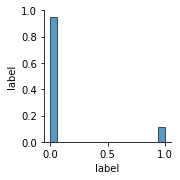

In [85]:
#fig, ax = plt.subplots(figsize=(10,6))
sns.pairplot(df) #En la diagonal aparece el histograma y en los demás gráficas una gráfica de dispersión
plt.show()

<AxesSubplot:xlabel='count', ylabel='Rubro1'>

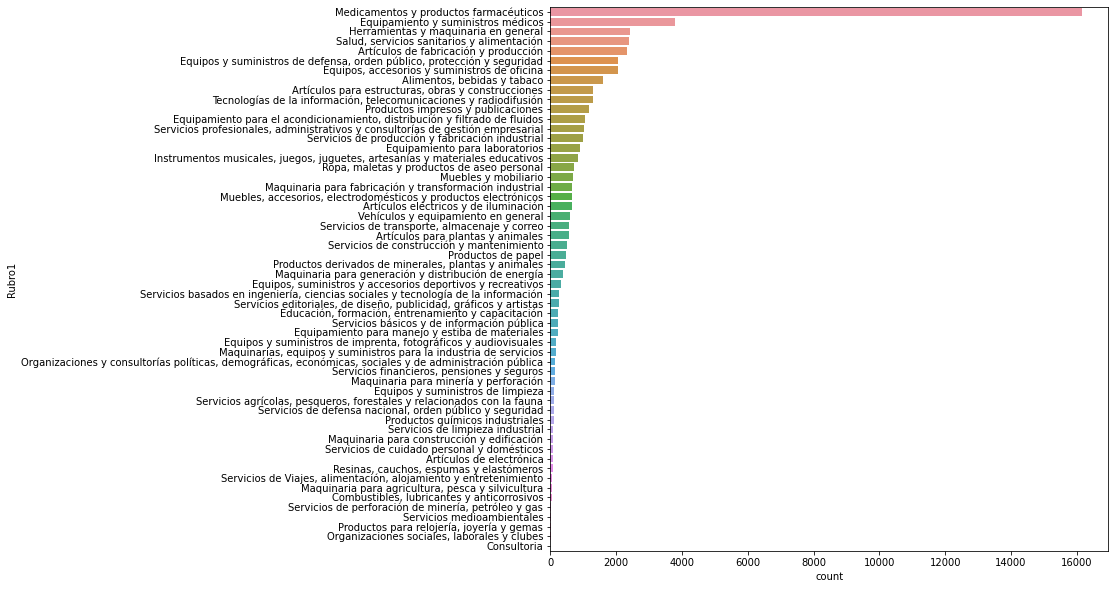

In [95]:
fig, ax = plt.subplots(figsize=(10,10))
sns.countplot(y= df['Rubro1'], order = df['Rubro1'].value_counts().index)

<AxesSubplot:xlabel='count', ylabel='Rubro1'>

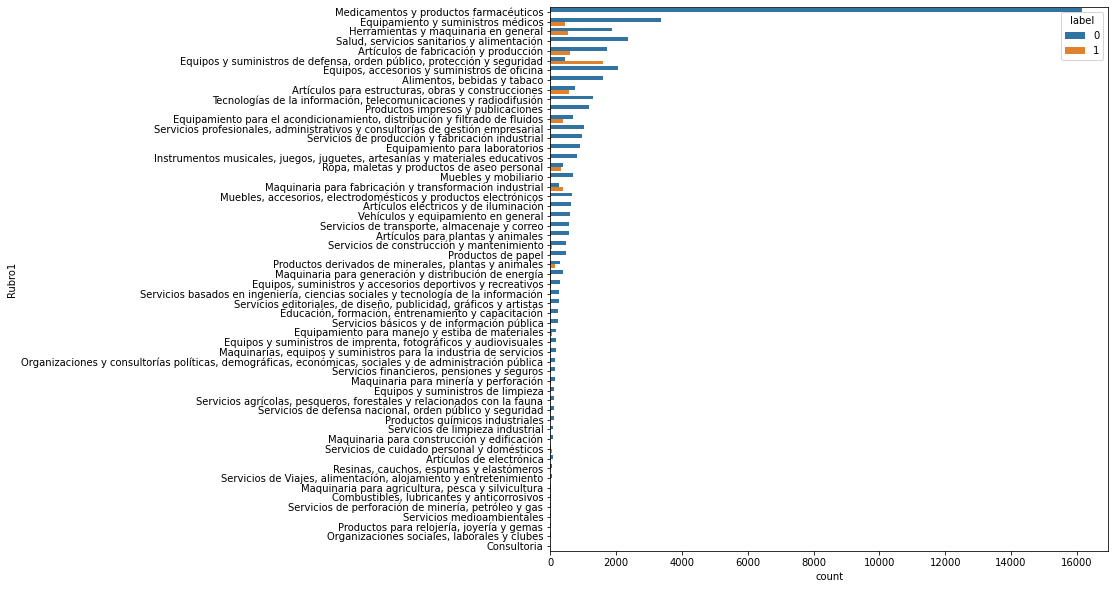

In [98]:
fig, ax = plt.subplots(figsize=(10,10))
sns.countplot(y= df['Rubro1'], hue=df['label'], order = df['Rubro1'].value_counts().index)

In [66]:
categorias_cliente = df[df['label']==1].groupby(['Rubro1','Rubro2','Rubro3','nombre_producto']).count()
categorias_cliente.sort_values('descripcion', ascending= False).head(20)

descripcion  \
Rubro1                                             Rubro2                                         Rubro3                                             nombre_producto                                                   
Equipos y suministros de defensa, orden público... Seguridad y control público                    Control de tráfico                                 Señales de tránsito                                         300   
                                                   Protección contra incendios                    Equipos para combatir incendios                    Extintores                                                  295   
Equipamiento para el acondicionamiento, distrib... Filtros y purificación industrial              Filtros                                            Filtros de aire                                             186   
Maquinaria para fabricación y transformación in... Maquinaria y suministros para talleres         Maquinaria para soldadura directa o indirecta      Soldadura                                                   184   
Equipos y suministros de defensa, orden público... Seguridad y protección personal                Ropa protectora de seguridad contra materias pe... Guantes protectores                                         180   
Artículos para estructuras, obras y construcciones Materiales estructurales básicos               Perfiles                                           Perfiles de acero                                           161   
Equipamiento y suministros médicos                 Equipos y suministros odontológicos            Rellenos y acabados dentales y suministros para... Discos de acabado o pulido                                  143   
Productos derivados de minerales, plantas y ani... Minerales y metales                            Metales base                                       Aleación ferrosa                                            132   
Equipos y suministros de defensa, orden público... Seguridad, vigilancia y detección              Equipo de vigilancia y detección                   Cámaras de seguridad                                        122   
Herramientas y maquinaria en general               Herramientas manuales                          Llaves, destornilladores y guías                   Llaves de torsión                                           106   
                                                                                                  Accesorios para herramientas                       Brocas                                                      103   
Ropa, maletas y productos de aseo personal         Calzado                                        Zapatos                                            Zapatos de hombre                                            98   
Equipamiento para el acondicionamiento, distrib... Filtros y purificación industrial              Filtros                                            Filtros de aceite                                            95   
Ropa, maletas y productos de aseo personal         Artículos de baño o tocador                    Artículos de baño y cuerpo                         Protector solar                                              93   
Equipamiento para el acondicionamiento, distrib... Filtros y purificación industrial              Filtros                                            Filtros de combustible                                       90   
Artículos de fabricación y producción              Materia prima en planchas, barras o tubos      Tubos y cañerías                                   Tubería de plástico                                          86   
Equipos y suministros de defensa, orden público... Seguridad y protección personal                Ropa protectora de seguridad contra materias pe... Ropa impermeable protectora o ropa para ambient...           83   
                                                   Seguridad y control público                   

In [70]:
#f[df['label']==1].groupby(['Rubro1']).size().sort_values(ascending=False)
df[df['label']==1].groupby('Rubro1')['Rubro1'].aggregate({'count'}).sort_values('count',ascending=False)/len(df[df['label']==1])

,count
Rubro1,
"Equipos y suministros de defensa, orden público, protección y seguridad",0.307102
Artículos de fabricación y producción,0.111871
Herramientas y maquinaria en general,0.099867
"Artículos para estructuras, obras y construcciones",0.098866
Equipamiento y suministros médicos,0.075525
"Equipamiento para el acondicionamiento, distribución y filtrado de fluidos",0.073525
Maquinaria para fabricación y transformación industrial,0.068690
"Ropa, maletas y productos de aseo personal",0.062354
"Productos derivados de minerales, plantas y animales",0.031010


<AxesSubplot:xlabel='count', ylabel='Rubro1'>

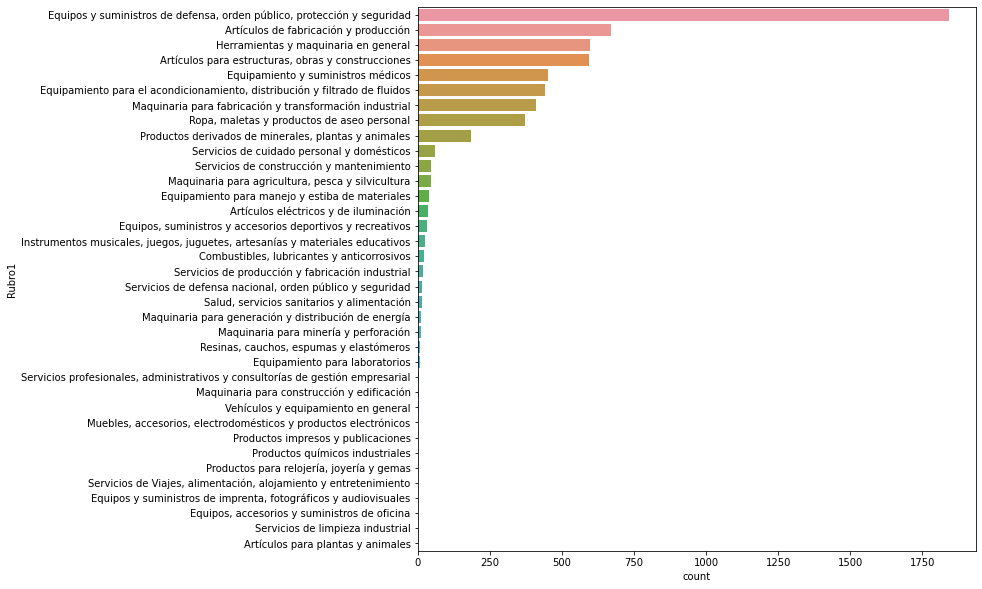

In [18]:
fig, ax = plt.subplots(figsize=(10,10))
sns.countplot(y = df[df['label']==1]['Rubro1'], 
    order = df[df['label']==1]['Rubro1'].value_counts().index)

In [ ]:
dist_label = df2.groupby('label').sum().T
dist_label.sort_values(1, ascending=False)


label,0,1
"Rubro1_Equipos y suministros de defensa, orden público, protección y seguridad",460.0,1605.0
Rubro1_Artículos de fabricación y producción,1726.0,602.0
"Rubro1_Artículos para estructuras, obras y construcciones",748.0,558.0
Rubro1_Herramientas y maquinaria en general,1879.0,542.0
Rubro1_Equipamiento y suministros médicos,3360.0,443.0
Rubro1_Maquinaria para fabricación y transformación industrial,275.0,394.0
"Rubro1_Equipamiento para el acondicionamiento, distribución y filtrado de fluidos",676.0,392.0
"Rubro1_Ropa, maletas y productos de aseo personal",393.0,314.0
"Rubro1_Productos derivados de minerales, plantas y animales",300.0,146.0
Rubro1_Servicios de cuidado personal y domésticos,19.0,59.0


<AxesSubplot:xlabel='count', ylabel='label'>

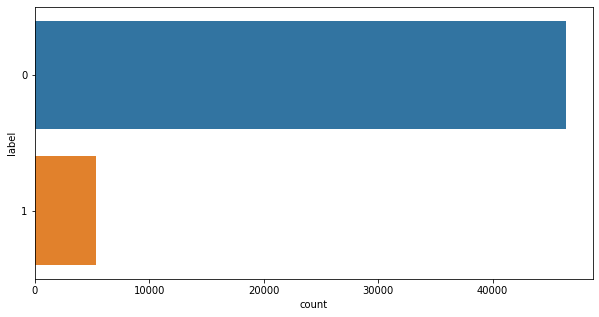

In [23]:
fig, ax = plt.subplots(figsize=(10,5))
sns.countplot(y= df['label'])

In [24]:
df.groupby('label')['label'].aggregate({'count'}).sort_values('count',ascending=False)/len(df)

,count
label,
0,0.895917
1,0.104083


## Análisis productos Mercado Publico

In [90]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 51795 entries, 2792-88-LE21-1 to 4309-381-LQ21-1
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Rubro1           51795 non-null  object
 1   Rubro2           51795 non-null  object
 2   Rubro3           51795 non-null  object
 3   nombre_producto  51795 non-null  object
 4   descripcion      51795 non-null  object
 5   label            51795 non-null  int64 
dtypes: int64(1), object(5)
memory usage: 2.8+ MB


In [8]:
productos_mp =pd.DataFrame()
productos_mp['nombre_producto']= df['nombre_producto'].astype(str)
productos_mp['producto limpio']= df['nombre_producto'].apply(lambda texto: texto_limpio(texto))
productos_mp['producto limpio raiz']= df['nombre_producto'].apply(lambda texto: texto_raiz(texto))
productos_mp['producto limpio raiz tk']= productos_mp['producto limpio raiz'].apply(lambda x:nltk.word_tokenize(x,"spanish"))
productos_mp.head()

,nombre_producto,producto limpio,producto limpio raiz,producto limpio raiz tk
id_producto,,,,
2792-88-LE21-1,Equipo quirúrgico de fragmatome retinal vítreo...,equipo quirurgico fragmatome retinal vitreo ac...,equip quirurg fragmatom retinal vitre accesori...,"[equip, quirurg, fragmatom, retinal, vitre, ac..."
1704-52-LP21-1,Servicios de transporte local en camión,servicios transporte local camion,servici transport local camion,"[servici, transport, local, camion]"
1003-20-L121-1,Desperdicios o restos de madera,desperdicios restos madera,desperdici rest mader,"[desperdici, rest, mader]"
4236-21-L121-1,Marcadores,marcadores,marcador,[marcador]
4236-21-L121-2,Péndulos,pendulos,pendul,[pendul]


In [97]:
palabras_productos = set([i for i in productos_mp['producto limpio']])
palabras = ''
for i in palabras_productos:
    palabras = palabras + ' ' +i

palabras_tk = productos_mp['producto limpio raiz tk'].sum()
palabras_unicas = set(palabras_tk)
len(palabras_unicas)

3777

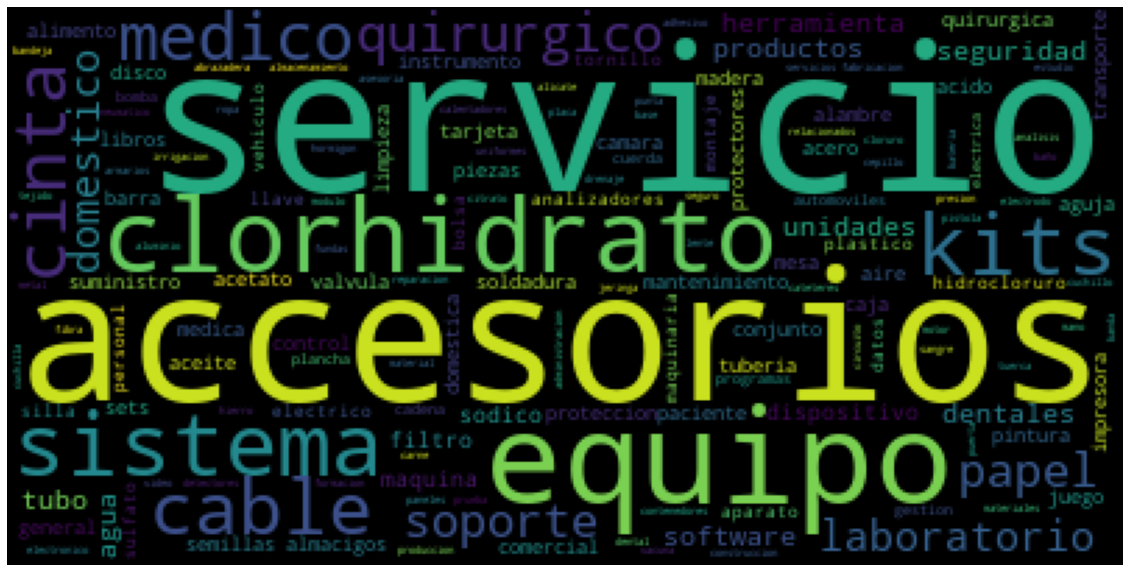

In [98]:
palabras_wc = WordCloud(background_color='black', max_words=len(palabras), stopwords=sw)
palabras_wc.generate(palabras)

fig, ax = plt.subplots(figsize=(20,20))
ax.imshow(palabras_wc)
ax.axis('off')
plt.show()

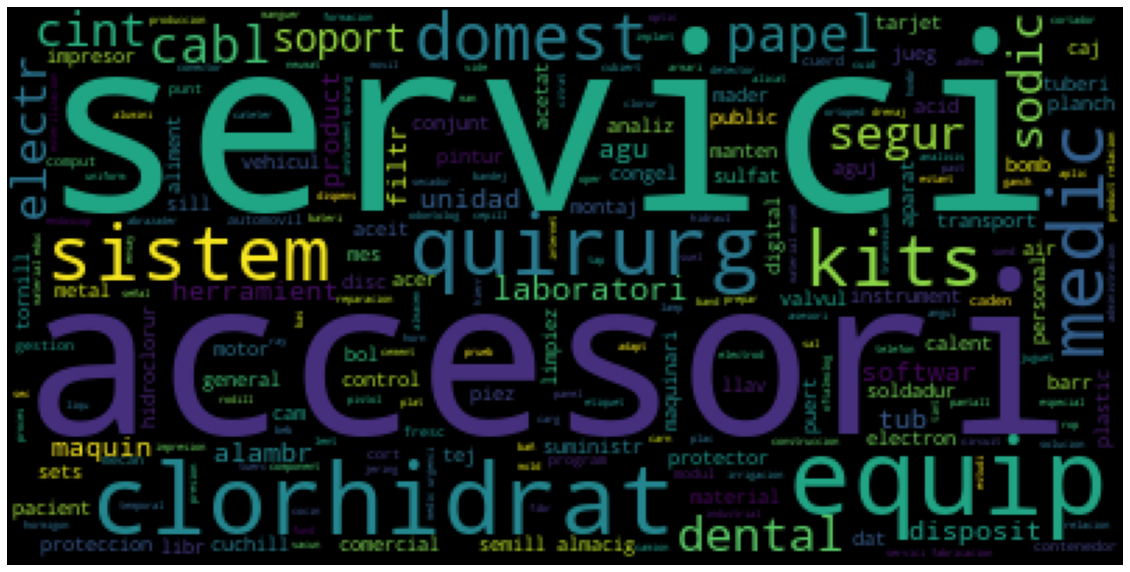

In [12]:
palabras_productos = set([i for i in productos_mp['producto limpio raiz']])
palabras = ''
for i in palabras_productos:
    palabras = palabras + ' ' +i

palabras_wc = WordCloud(background_color='black', max_words=len(palabras), stopwords=sw)
palabras_wc.generate(palabras)

fig, ax = plt.subplots(figsize=(20,20))
ax.imshow(palabras_wc)
ax.axis('off')
plt.show()

In [10]:
productos_mp_cli =pd.DataFrame()
productos_mp_cli['nombre_producto']= df[df['label']==1]['nombre_producto'].astype(str)
productos_mp_cli['producto limpio']= df[df['label']==1]['nombre_producto'].apply(lambda texto: texto_limpio(texto))
productos_mp_cli['producto limpio raiz']= df[df['label']==1]['nombre_producto'].apply(lambda texto: texto_raiz(texto))
productos_mp_cli['producto limpio raiz tk']= productos_mp_cli['producto limpio raiz'].apply(lambda x:nltk.word_tokenize(x,"spanish"))
productos_mp_cli.head()

,nombre_producto,producto limpio,producto limpio raiz,producto limpio raiz tk
id_producto,,,,
4236-21-L121-6,Cintas métricas,cintas metricas,cint metric,"[cint, metric]"
4236-21-L121-11,Discos de acabado o pulido,discos acabado pulido,disc acab pul,"[disc, acab, pul]"
4236-21-L121-12,Soldadura,soldadura,soldadur,[soldadur]
4236-21-L121-14,Aleación ferrosa,aleacion ferrosa,aleacion ferros,"[aleacion, ferros]"
4236-21-L121-15,Aleación ferrosa,aleacion ferrosa,aleacion ferros,"[aleacion, ferros]"


In [13]:
palabras_productos = set([i for i in productos_mp_cli['producto limpio']])
palabras = ''
for i in palabras_productos:
    palabras = palabras + ' ' +i

palabras_tk = productos_mp_cli['producto limpio raiz tk'].sum()
palabras_unicas = set(palabras_tk)
len(palabras_unicas)

666

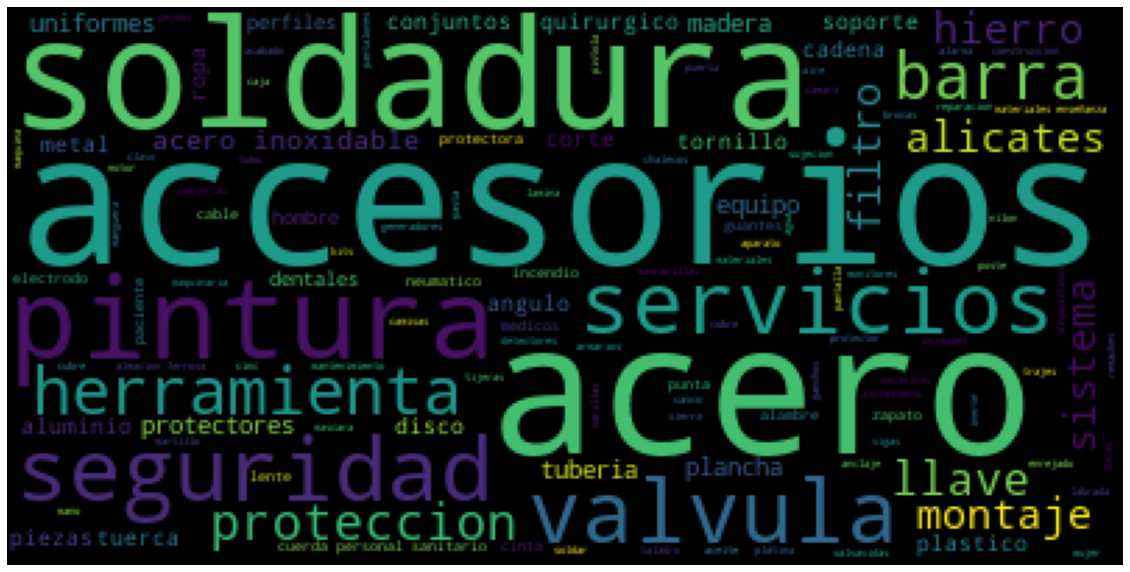

In [15]:
palabras_wc = WordCloud(background_color='black', max_words=len(palabras), stopwords=sw)
palabras_wc.generate(palabras)

fig, ax = plt.subplots(figsize=(20,20))
ax.imshow(palabras_wc)
ax.axis('off')
plt.show()

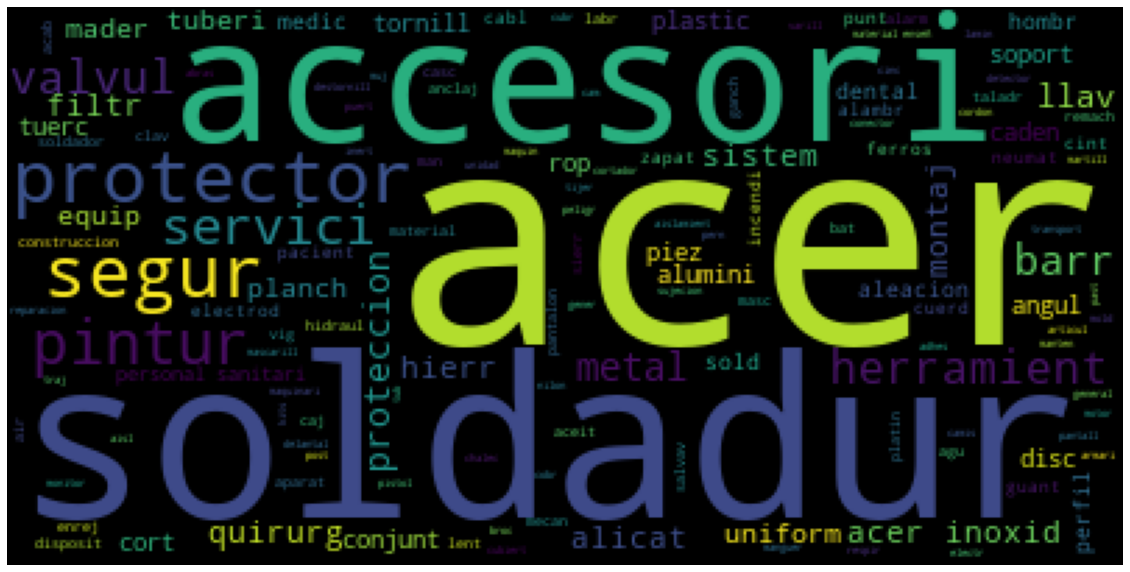

In [16]:
palabras_productos = set([i for i in productos_mp_cli['producto limpio raiz']])
palabras = ''
for i in palabras_productos:
    palabras = palabras + ' ' +i

palabras_wc = WordCloud(background_color='black', max_words=len(palabras), stopwords=sw)
palabras_wc.generate(palabras)

fig, ax = plt.subplots(figsize=(20,20))
ax.imshow(palabras_wc)
ax.axis('off')
plt.show()


## Análisis palabras catalogo de productos

In [17]:
'carga inicial dataset desde archivo csv a un objeto panda'
productos_catalogo = pd.read_csv(r'..\Datos\cat_prod.csv', delimiter=';')
productos_catalogo

,Material,Material desc,Grupo art. Desc,Jerar,NEGOCIO desc,Tipo producto,Familia
0,2256,"ELECTRODO LINCOLN E-308 L/16 3/32""",ACEROS IN,\tSOLDADURA ESPECECIAL,SOLDADURA Y CORTE,Soldaduras,Electrodo
1,2257,"ELECTRODO LINCOLN E-308 L/16 1/8""",ACEROS IN,\tSOLDADURA ESPECECIAL,SOLDADURA Y CORTE,Soldaduras,Electrodo
2,2258,"ELECTRODO LINCOLN E-308 L/16 5/32""",ACEROS IN,\tSOLDADURA ESPECECIAL,SOLDADURA Y CORTE,Soldaduras,Electrodo
3,2261,"ELECTRODO LINCOLN E-312 L/16 3/32""",ACEROS IN,\tSOLDADURA ESPECECIAL,SOLDADURA Y CORTE,Soldaduras,Electrodo
4,2262,"ELECTRODO LINCOLN E-312 L/16 1/8""",ACEROS IN,\tSOLDADURA ESPECECIAL,SOLDADURA Y CORTE,Soldaduras,Electrodo
...,...,...,...,...,...,...,...
11209,68005,ARNES 3M SAFELIGHT 10911 3 ARGOLLAS,PROTECCION DE CAIDAS,\tPROTECCION CAIDAS,NaN,Protección de caídas,NaN
11210,143278,Mascarilla BLS FFP2 NR D sin válvula 20 UN,RESPIRADORES DESCART,\tPROTECCION RESPIRATORIA,NaN,Protección respiratoria,NaN
11211,111431,Anteojo Atox Dallas Clear,\tINICIATIVA GETPRO,\tPROTECCION OCULAR,NaN,Protección ocular,NaN
11212,68526,Filtro Mixto 3M vapores orga?nicos,\tEQUIPOS DE RESPIRACION,\tPROTECCION RESPIRATORIA,NaN,Protección respiratoria,NaN


In [18]:
productos_catalogo['Material desc']= productos_catalogo['Material desc'].astype(str)
productos_catalogo['producto limpio']= productos_catalogo['Material desc'].apply(lambda texto: texto_limpio(texto))
productos_catalogo['producto limpio raiz']= productos_catalogo['Material desc'].apply(lambda texto: texto_raiz(texto))
productos_catalogo['producto limpio raiz tk']= productos_catalogo['producto limpio raiz'].apply(lambda x:nltk.word_tokenize(x,"spanish"))
productos_catalogo.head()

,Material,Material desc,Grupo art. Desc,Jerar,NEGOCIO desc,Tipo producto,Familia,producto limpio,producto limpio raiz,producto limpio raiz tk
0,2256,"ELECTRODO LINCOLN E-308 L/16 3/32""",ACEROS IN,\tSOLDADURA ESPECECIAL,SOLDADURA Y CORTE,Soldaduras,Electrodo,electrodo lincoln,electrod lincoln,"[electrod, lincoln]"
1,2257,"ELECTRODO LINCOLN E-308 L/16 1/8""",ACEROS IN,\tSOLDADURA ESPECECIAL,SOLDADURA Y CORTE,Soldaduras,Electrodo,electrodo lincoln,electrod lincoln,"[electrod, lincoln]"
2,2258,"ELECTRODO LINCOLN E-308 L/16 5/32""",ACEROS IN,\tSOLDADURA ESPECECIAL,SOLDADURA Y CORTE,Soldaduras,Electrodo,electrodo lincoln,electrod lincoln,"[electrod, lincoln]"
3,2261,"ELECTRODO LINCOLN E-312 L/16 3/32""",ACEROS IN,\tSOLDADURA ESPECECIAL,SOLDADURA Y CORTE,Soldaduras,Electrodo,electrodo lincoln,electrod lincoln,"[electrod, lincoln]"
4,2262,"ELECTRODO LINCOLN E-312 L/16 1/8""",ACEROS IN,\tSOLDADURA ESPECECIAL,SOLDADURA Y CORTE,Soldaduras,Electrodo,electrodo lincoln,electrod lincoln,"[electrod, lincoln]"


In [19]:
palabras_productos = set([i for i in productos_catalogo['producto limpio']])
palabras = ''
for i in palabras_productos:
    palabras = palabras + ' ' +i

palabras_tk = productos_catalogo['producto limpio raiz tk'].sum()
palabras_unicas = set(palabras_tk)
len(palabras_unicas)

2187

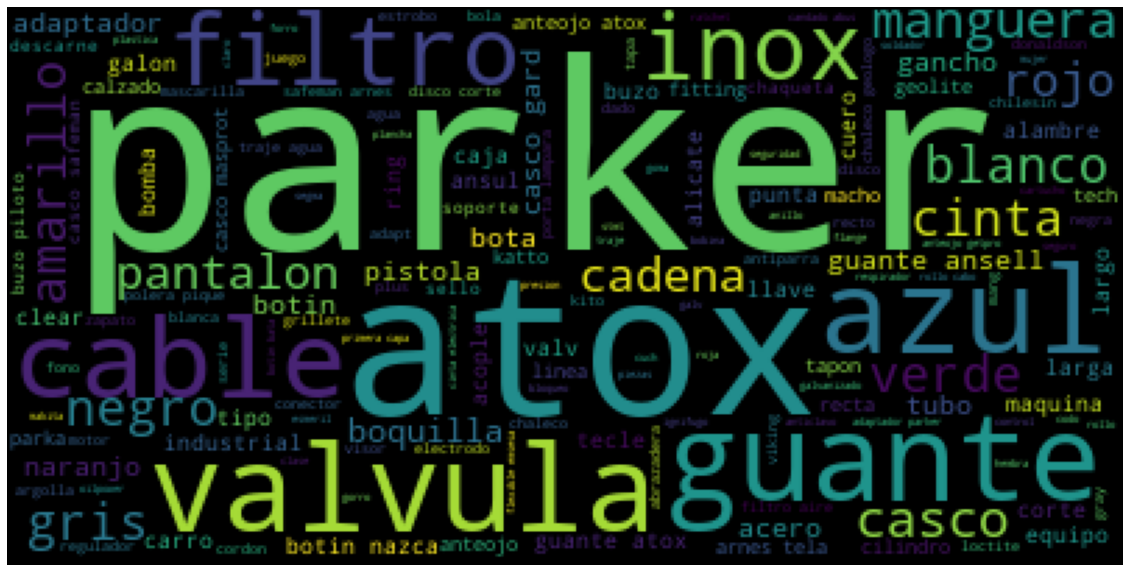

In [20]:
palabras_wc = WordCloud(background_color='black', max_words=len(palabras), stopwords=sw)
palabras_wc.generate(palabras)

fig, ax = plt.subplots(figsize=(20,20))
ax.imshow(palabras_wc)
ax.axis('off')
plt.show()

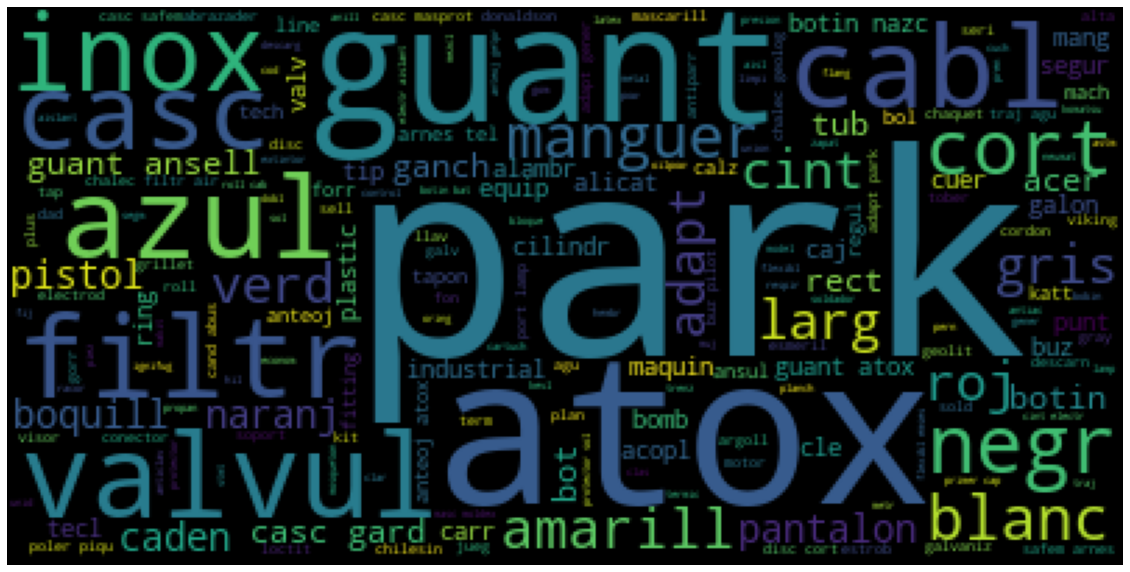

In [21]:
palabras_productos = set([i for i in productos_catalogo['producto limpio raiz']])
palabras = ''
for i in palabras_productos:
    palabras = palabras + ' ' +i

palabras_wc = WordCloud(background_color='black', max_words=len(palabras), stopwords=sw)
palabras_wc.generate(palabras)

fig, ax = plt.subplots(figsize=(20,20))
ax.imshow(palabras_wc)
ax.axis('off')
plt.show()

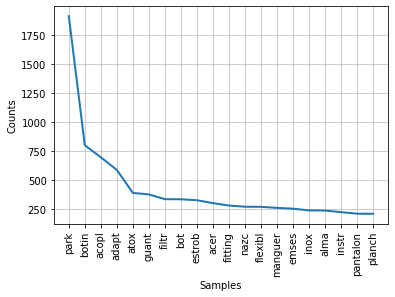

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [41]:
nltk.FreqDist(nltk.Text(palabras_tk)).plot(20)

In [18]:
df['descripcion']= df['descripcion'].astype(str)
df['Descripcion raiz limpia']= df['descripcion'].apply(lambda texto: texto_raiz(texto)) #Aplicamos la función texto_raiz que nos convierte las palabras en sus raíces

In [19]:
# creamos un vocabulario en base a las palabras del catalogo
descripcion = np.array(productos_catalogo['producto limpio raiz'])

count = CountVectorizer()
count.fit(descripcion)
#aplicamos el count de palabras sobre el dataset de licitaciones mercado publico 
bag = count.transform(df['Descripcion raiz limpia'])
df_bag = pd.DataFrame(bag.toarray())  # el array de matriz palabras pasamos a dataframe
df_bag.columns = count.get_feature_names() # agregamos nombres a las columnas con las palabras del vocabulario
df_bag.head()

,aaab,abaj,abat,abek,abra,abraz,abrazader,abrig,abrzader,absolut,...,zapat,zapatill,zer,zhbf,zinc,zipp,zippers,zlcf,zlrkdscf,zytron
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
lista_columnas = df_bag.columns
lista_columnas

Index(['aaab', 'abaj', 'abat', 'abek', 'abra', 'abraz', 'abrazader', 'abrig',
       'abrzader', 'absolut',
       ...
       'zapat', 'zapatill', 'zer', 'zhbf', 'zinc', 'zipp', 'zippers', 'zlcf',
       'zlrkdscf', 'zytron'],
      dtype='object', length=2187)

In [27]:
lc = open('lista_columnas.pkl','wb')
pickle.dump(lista_columnas,lc)
lc.close()

In [20]:
n_palabras= count.vocabulary_ #vocabulario catalogo productos
distribucion = nltk.FreqDist(n_palabras) #frecuencia palabras en catalogo de productos
lista_frecuencias = distribucion.most_common() #Para ordenar la distribución de la frecuencia de palabras
lista_frecuencias

[('zytron', 2186),
 ('zlrkdscf', 2185),
 ('zlcf', 2184),
 ('zippers', 2183),
 ('zipp', 2182),
 ('zinc', 2181),
 ('zhbf', 2180),
 ('zer', 2179),
 ('zapatill', 2178),
 ('zapat', 2177),
 ('yug', 2176),
 ('yok', 2175),
 ('yardbird', 2174),
 ('yalic', 2173),
 ('yak', 2172),
 ('xxxl', 2171),
 ('xtrem', 2170),
 ('xpow', 2169),
 ('xpert', 2168),
 ('xomox', 2167),
 ('xjpb', 2166),
 ('wypall', 2165),
 ('wrench', 2164),
 ('wom', 2163),
 ('wntx', 2162),
 ('wlnl', 2161),
 ('wjjmlos', 2160),
 ('wings', 2159),
 ('whipchek', 2158),
 ('weld', 2157),
 ('wearshield', 2156),
 ('wav', 2155),
 ('watt', 2154),
 ('wat', 2153),
 ('wash', 2152),
 ('warrior', 2151),
 ('waex', 2150),
 ('wad', 2149),
 ('vxbg', 2148),
 ('vsti', 2147),
 ('vrss', 2146),
 ('vrmm', 2145),
 ('volum', 2144),
 ('vitx', 2143),
 ('viton', 2142),
 ('vitali', 2141),
 ('visual', 2140),
 ('visor', 2139),
 ('visivil', 2138),
 ('visit', 2137),
 ('visibil', 2136),
 ('vinil', 2135),
 ('viking', 2134),
 ('viii', 2133),
 ('vig', 2132),
 ('vient', 213